In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/09/17 00:28:09 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.28.42.139 instead (on interface eth0)
22/09/17 00:28:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/17 00:28:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/17 00:28:11 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
sdf = spark.read.parquet("../data/curated/mergedf.parquet/")

In [3]:
merchantdf = spark.read.parquet("../data/tables/tbl_merchants.parquet")
merchantdf = merchantdf.withColumnRenamed("name","company_name")

# Replace all square brackets with round brackets
merchantdf = merchantdf.withColumn('tags', regexp_replace('tags', '\\[', '\\('))
merchantdf = merchantdf.withColumn('tags', regexp_replace('tags', '\\]', '\\)'))

# Extract take rate into seperate column
merchantdf = merchantdf.withColumn("take_rate", 
                                   split(col("tags"), "\\),").getItem(2))\
                       .withColumn('take_rate', 
                                   regexp_replace('take_rate', 'take rate: ', 
                                                  ''))\
                       .withColumn('take_rate', 
                                   regexp_replace('take_rate', '\\(', ''))\
                       .withColumn('take_rate', 
                                   regexp_replace('take_rate', '\\)', ''))

# Extract revenue band
merchantdf = merchantdf.withColumn("revenue_band", 
                                   split(col("tags"), "\\),").getItem(1))\
                       .withColumn('revenue_band', 
                                   regexp_replace('revenue_band', '\\(', ''))\
                       .withColumn('revenue_band', 
                                   regexp_replace('revenue_band', '\\)', ''))

# Extract tags band
merchantdf = merchantdf.withColumn("tags", 
                                   split(col("tags"), "\\),").getItem(0))\
                       .withColumn('tags', 
                                   regexp_replace('tags', '\\(', ''))\
                       .withColumn('tags', 
                                   regexp_replace('tags', '\\)', ''))\
                       .withColumn('tags', 
                                   regexp_replace('tags', ' +', ' '))\
                       .withColumn('tags', 
                                   lower('tags'))

In [4]:
transactiondf1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")
transactiondf2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot/")
transactiondf = transactiondf1.union(transactiondf2)
userdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")

## Revenue Band

  revenue_band  count
0            a   1602
1            b   1351
2            c    922
3            d     98
4            e     53
  revenue_band    count
0            a  3509188
1            b  2251496
2            c  1909472
3            d    78521
4            e    69053


<AxesSubplot:title={'center':'Distribution of Merchant Revenue Bands'}, ylabel='count'>

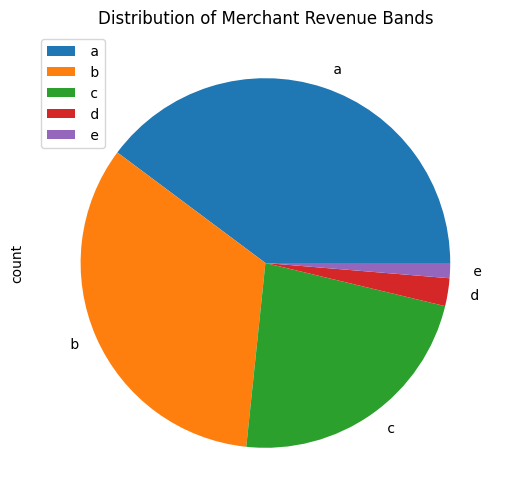

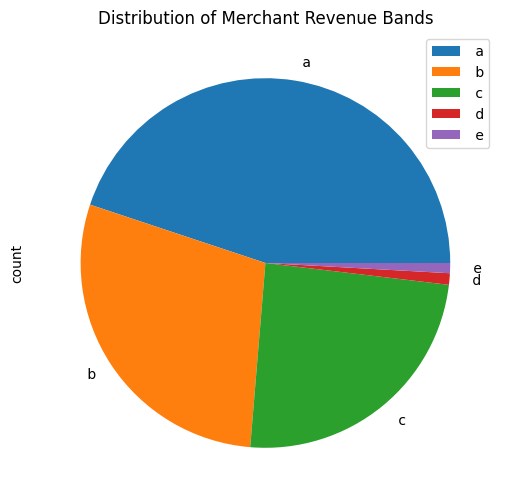

In [5]:
## Revenue Band
print(merchantdf.groupby('revenue_band').count().sort('revenue_band').toPandas())
merchantdf.groupby('revenue_band').count().sort('revenue_band').toPandas().set_index('revenue_band')\
.plot(kind='pie', y='count', figsize=(9, 6), legend=True, title="Distribution of Merchant Revenue Bands")

## Now do all transactions have valid revenue bands?
print(sdf.groupby('revenue_band').count().sort('revenue_band').toPandas())
sdf.groupby('revenue_band').count().sort('revenue_band').toPandas().set_index('revenue_band')\
.plot(kind='pie', y='count', figsize=(9, 6), legend=True, title="Distribution of Merchant Revenue Bands")

Even after splitting from the tags field, we do not see any invalid entries in the revenue band field. The majority of revenue bands lie between a-c, with d and e revenue bands clearly being reserved for the most extreme merchants. Overall the number of merchants decreases as you reach higher revenue bands.

## Take Rate

           count
take_rate       
5.91        20.0
5.73        19.0
5.99        19.0
6.43        19.0
5.55        18.0
5.62        17.0
6.33        17.0
5.68        16.0
6.30        16.0
5.64        16.0
6.57        16.0
5.65        15.0
6.01        15.0
5.71        15.0
4.97        15.0
6.26        14.0
6.72        14.0
6.42        14.0
5.97        14.0
3.61        14.0


              count
take_rate          
2.94       178872.0
6.43       171107.0
2.86       161561.0
5.80       159912.0
1.47       152054.0
2.93       146435.0
6.01       142947.0
6.98       139087.0
6.48       120560.0
4.47       118167.0
6.33        85179.0
5.65        83699.0
5.73        67659.0
4.69        64976.0
6.61        61360.0
4.95        58971.0
5.97        58761.0
5.93        52668.0
6.16        49903.0
5.05        49661.0


Text(0, 0.5, 'Frequency')

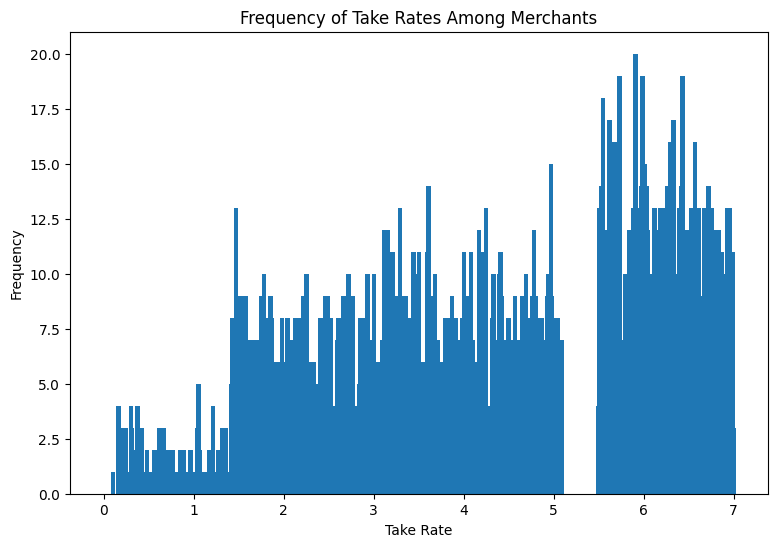

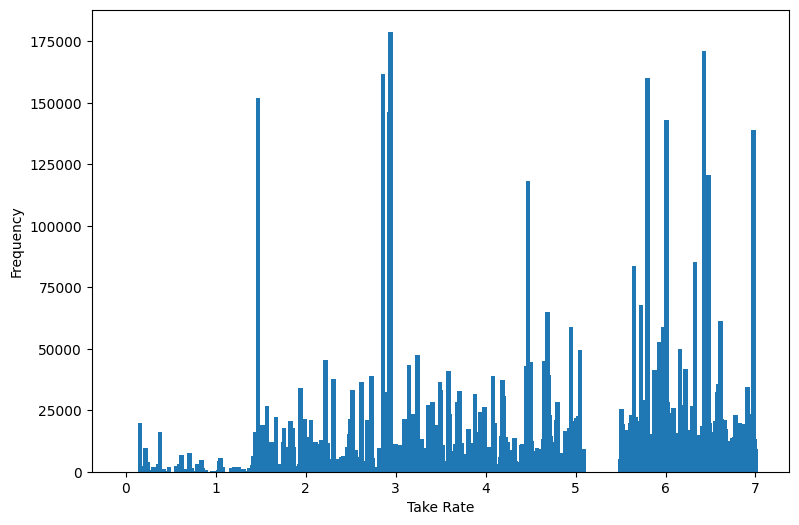

In [6]:
takerate_df = pd.DataFrame({"take_rate":np.arange(0, 7.01, 0.01), "count": 0})\
.set_index("take_rate")
takerate_df['count'] = merchantdf.groupby('take_rate').count().sort('take_rate')\
.toPandas().astype({'take_rate':'float'}).set_index('take_rate')
takerate_df = takerate_df.fillna(0)
print(takerate_df.sort_values('count', ascending=False).head(20))

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(takerate_df.index, takerate_df['count'], width=0.05)
plt.xlabel('Take Rate')
plt.ylabel('Frequency')
plt.title('Frequency of Take Rates Among Merchants')


## Now do all transactions have valid take rates?
takerate_df = pd.DataFrame({"take_rate":np.arange(0, 7.01, 0.01), "count": 0})\
.set_index("take_rate")
takerate_df['count'] = sdf.groupby('take_rate').count().sort('take_rate')\
.toPandas().astype({'take_rate':'float'}).set_index('take_rate')
takerate_df = takerate_df.fillna(0)
print(takerate_df.sort_values('count', ascending=False).head(20))
fig, ax = plt.subplots(figsize=(9,6))
ax.bar(takerate_df.index, takerate_df['count'], width=0.05)
plt.xlabel('Take Rate')
plt.ylabel('Frequency')

There appears to be 3 distinct 'groups' in the distribution of take rate. The first comprising of very few merchants, which have a take rate between 0% and just over 1%. Rather logically, no merchants have a take rate of 0, and we don't see any nonsensical take rates either, such as negative take rates. 

The second group composes of merchants with a take take of just over 1% to roughly 5%. The number of merchants in this groups appears to have jumped significantly as compared to the previous group.

We notice a rather interesting pattern in that no merchants appear to have a take rate between just over 5% and roughly 5.5%. This could have something to do with the method used to determine take rate? Could make sense particularly with what appears to be 3 clear groups. 

The final group contains merchants between 5.5% take rate, and what appears to be the maximum possible take rate of 7%.

Finally, inside of each of the 3 groups, take rate appears to be uniformally distributed.

## Tags

In [7]:
merchantdf.groupby('tags').count().sort('tags').count()
merchantdf.groupby('tags').count().sort('tags').show(100, truncate=False)

# Now for transactions
sdf.groupby('tags').count().sort('tags').show(100, truncate=False)

+-------------------------------------------------------------------------------------+-----+
|tags                                                                                 |count|
+-------------------------------------------------------------------------------------+-----+
|antique shops - sales, repairs, and restoration services                             |129  |
|art dealers and galleries                                                            |112  |
|artist supply and craft shops                                                        |193  |
|bicycle shops - sales and service                                                    |170  |
|books, periodicals, and newspapers                                                   |164  |
|cable, satellite, and other pay television and radio services                        |175  |
|computer programming , data processing, and integrated systems design services       |191  |
|computers, computer peripheral equipment, and software     

After cleaning up the field, there are actually only 25 different unique values for tags, with these being fairly evenly distributed amongst merchants. This is a fairly interesting finding, since it was at first thought that this field was unique to each vendor, particularly given its nature as being a field manually entered

The maximum count shows 195 merchants with tag 'digital goods: books, movies, music' and minimum count shows 91 merchants with tag 'jewelry, watch, clock and silverware shops'.

Viewing the occurences of these tags in transactions instead reveals certain tags are associated with more/less frequent transactions. For example, 'jewelry, watch, clock, and silverware shops' merchants are seen to have by far the least frequent amount of transaction as opposed to 'tent and awning shops' which have the most by far.

# Consumer ID/User ID

In [8]:
print(userdf.groupby('consumer_id').count().sort(desc('count')))
print(userdf.groupby('consumer_id').count().sort(desc('count')).count())
print(userdf.groupby('user_id').count().sort(desc('count')))
print(userdf.groupby('user_id').count().sort(desc('count')).count())
print(transactiondf.groupby('user_id').count().sort('user_id').count())
print(transactiondf.groupby('user_id').count().sort('count'))

+-----------+-----+
|consumer_id|count|
+-----------+-----+
|     367113|    1|
|    1255411|    1|
|     999838|    1|
|    1406677|    1|
|     331653|    1|
|     105297|    1|
|     893193|    1|
|    1093060|    1|
|     147768|    1|
|     194306|    1|
|    1402299|    1|
|     393166|    1|
|    1471150|    1|
|     615626|    1|
|      78271|    1|
|     467704|    1|
|     832715|    1|
|     168801|    1|
|      61300|    1|
|    1253794|    1|
+-----------+-----+
only showing top 20 rows

499999
+-------+-----+
|user_id|count|
+-------+-----+
|     41|    1|
|    499|    1|
|    907|    1|
|   1085|    1|
|   1114|    1|
|   1273|    1|
|   1473|    1|
|   1574|    1|
|   1689|    1|
|   1695|    1|
|   1716|    1|
|   1783|    1|
|   2051|    1|
|   2171|    1|
|   2474|    1|
|   2556|    1|
|   2825|    1|
|   2935|    1|
|   3017|    1|
|   3108|    1|
+-------+-----+
only showing top 20 rows

499999


24081
+-------+-----+
|user_id|count|
+-------+-----+
|  11982|  285|
|  22367|  286|
|   8755|  289|
|   4760|  290|
|   2713|  291|
|  23378|  292|
|  21598|  292|
|   4794|  292|
|  17995|  294|
|   9026|  294|
|   5989|  295|
|   6183|  295|
|  16332|  296|
|  13052|  296|
|   2150|  296|
|   1510|  296|
|   8905|  296|
|  12950|  297|
|  20629|  297|
|  13951|  297|
+-------+-----+
only showing top 20 rows



There are no problems caused by joining this table (apart from the strange inclusion of a surrogate key). This table simply maps all user_ids from 0-499999 to some consumer_id. However, in the data given only user_ids up to 24,081 actually have at least 1 valid transaction in the dataset, meaning many of these mappings appear to go unused.

## Invalid Transactions

In [9]:
print(transactiondf.count() - sdf.count())

333642


By simply joining all tables to the transaction table via the relevant foreign keys, any transaction which can't be joined for some reason will be discarded. As seen above, this would mean that 333,642 transactions (as of the end of Week 2 data) would be simply discarded without our knowledge.

In [10]:
dropped_transactions = transactiondf.join(sdf, 'order_id', "leftanti")
dropped_transactions.count()

333642

In [11]:
dropped_transactions

order_id,user_id,merchant_abn,dollar_value,order_datetime
00010154-c8c6-492...,14132,43820812476,145.7508223047609,2021-04-03
0001f004-f3b9-479...,9553,48540087213,2535.012136880364,2021-03-24
000334fe-7ab8-4e7...,2438,11240426404,161.65965550330247,2021-05-01
000a5afb-4c3b-458...,14983,33604812025,174.06729685924134,2021-05-01
000c6979-a96c-468...,1221,29323795999,0.583128432753908,2021-08-15
0012083d-3d78-4a6...,21522,73121558118,76.2031996487711,2021-04-30
0016c89c-7e71-4c2...,9410,95492562735,30.124085051663126,2021-05-24
0017b5e7-2cf3-494...,2088,87802246756,184.15325198043612,2021-06-21
001dab75-e07a-425...,7020,32234779638,177.6279422305109,2021-04-23
00230efc-c131-498...,20787,63966446164,172.42893653118102,2021-04-22


In [12]:
print(dropped_transactions.filter(dropped_transactions.user_id > 24081))

+--------+-------+------------+------------+--------------+
|order_id|user_id|merchant_abn|dollar_value|order_datetime|
+--------+-------+------------+------------+--------------+
+--------+-------+------------+------------+--------------+



All transactions appear to have a valid user id.

In [13]:
print(dropped_transactions.groupby('merchant_abn').count().count())
print(dropped_transactions.groupby('merchant_abn').count().sort('merchant_abn'))
print(dropped_transactions.join(merchantdf, "merchant_abn"))

395


22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/17 00:28:52 WARN RowBasedKeyValueBatch: Calling spill() on

+------------+-----+
|merchant_abn|count|
+------------+-----+
| 10672322914|   64|
| 11029341140|   11|
| 11137507330| 1159|
| 11240426404|31216|
| 11358147682|   50|
| 11400713351|   35|
| 11839682616|  431|
| 12959561070|    1|
| 13129485817|    6|
| 13177076095|  185|
| 13226823813|  328|
| 13289167958|    7|
| 13494073581|   15|
| 13868849576|  469|
| 14827550074|  830|
| 15058508937|   23|
| 15073921424|   10|
| 15699401518|  142|
| 15862090061|  144|
| 16496390781|   44|
+------------+-----+
only showing top 20 rows



+------------+--------+-------+------------+--------------+------------+----+---------+------------+
|merchant_abn|order_id|user_id|dollar_value|order_datetime|company_name|tags|take_rate|revenue_band|
+------------+--------+-------+------------+--------------+------------+----+---------+------------+
+------------+--------+-------+------------+--------------+------------+----+---------+------------+



Therefore, all invalid transactions are shown to be dropped because they do not have a valid merchant_abn to link to. Maybe one might want to consider all these merchants as if they shared the same tag, however removing them would also seem sensible.

## Merchants

In [14]:
no_transaction_merchants = merchantdf.join(sdf.groupby('merchant_abn').count(), 'merchant_abn', "leftanti")
no_transaction_merchants

merchant_abn,company_name,tags,take_rate,revenue_band
76866488151,Euismod Urna Company,antique shops - s...,4.08,b
46537010521,Tempor Augue Ac C...,"jewelry, watch, c...",2.18,c
55555661470,Nullam Scelerisqu...,"jewelry, watch, c...",1.83,c
28311306642,Egestas Nunc Sed LLC,antique shops - s...,4.93,b
47047735645,Aenean Gravida In...,antique shops - s...,1.54,c
55403018592,Elit Limited,antique shops - s...,4.84,b
93267734067,Curae Foundation,"jewelry, watch, c...",2.57,c


There are therefore 7 merchants in the merchant dataframe that do not have a single transaction present in the transactional database as of yet. Of interest is their shared tags, only being either antique shops or jewelry etc. stores. We don't really have to remove these per say, they will exist in case any future transactions released have transactions of these merchants. 

In [15]:
## External Dataset Sources

SA2 Shapefile: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files


SA2 + Postcode dataset = https://www.matthewproctor.com/australian_postcodes?simple=True 

External income dataset = https://data.aurin.org.au/dataset/au-govt-abs-abs-personal-income-total-income-sa2-2011-2018-sa2-2016

## Postcodes (JAI: needa have a script download postcode file)

In [16]:
postcodedf = spark.read.option("header","true").csv("../data/tables/australian_postcodes.csv")
postcodedf.limit(5)

22/09/17 00:29:02 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


id,postcode,locality,state,long,lat,dc,type,status,sa3,sa3name,sa4,sa4name,region,Lat_precise,Long_precise,SA1_MAINCODE_2011,SA1_MAINCODE_2016,SA2_MAINCODE_2016,SA2_NAME_2016,SA3_CODE_2016,SA3_NAME_2016,SA4_CODE_2016,SA4_NAME_2016,RA_2011,RA_2016,MMM_2015,MMM_2019,ced,altitude,chargezone,phn_code,phn_name,lgaregion,electorate,electoraterating
230,0200,ANU,ACT,149.119,-35.2777,null,null,null,null,null,null,null,R1,-35.2777,149.119,80105104901,80105104901,801051049,Acton,80105,North Canberra,801,Australian Capita...,1,1,1,1,null,null,N2,null,null,null,Durack,null
21820,0200,Australian Nation...,ACT,149.1189,-35.2777,null,null,Added 19-Jan-2020,null,null,null,null,R1,-35.2776999,149.118527,80105104901,80105104901,801051049,Acton,80105,North Canberra,801,Australian Capita...,1,1,1,1,null,null,N2,null,null,null,Durack,null
232,0800,DARWIN,NT,130.83668,-12.458684,null,null,Updated 6-Feb-2020,70101,Darwin City,701,Darwin,R1,-12.3932794,130.7766611,70101100203,70101100218,701011002,Darwin City,70101,Darwin City,701,Darwin,3,3,2,2,null,null,NT1,PHN701,Northern Territory,Darwin,Solomon,Inner Metropolitan
24049,0800,DARWIN CITY,NT,130.83668,-12.458684,null,null,Updated 6-Feb-2020,70101,Darwin City,701,Darwin,R1,-12.3932794,130.7766611,70101100203,70101100218,701011002,Darwin City,70101,Darwin City,701,Darwin,3,3,2,2,null,null,NT1,PHN701,Northern Territory,Darwin,Solomon,Inner Metropolitan
233,0801,DARWIN,NT,130.83668,-12.458684,null,null,Updated 25-Mar-20...,70101,Darwin City,701,Darwin,R1,-12.4634403,130.8456418,70101100208,70101100208,701011002,Darwin City,70101,Darwin City,701,Darwin,3,3,2,2,null,null,NT1,PHN701,null,null,Lingiari,Rural


In [17]:
from pyspark.sql import Row

testpostcodedf = postcodedf.select("SA2_MAINCODE_2016","locality","state","SA2_NAME_2016")
testpostcodedf = testpostcodedf.withColumnRenamed("SA2_MAINCODE_2016","sa2_code")

postcodedf = postcodedf.select("postcode","SA2_MAINCODE_2016")
postcodedf = postcodedf.withColumnRenamed("SA2_MAINCODE_2016","sa2_code")
print(postcodedf.count())

postcodedf = postcodedf.dropna("any")
print(postcodedf.count())

postcodedf = postcodedf.distinct()
print(postcodedf.count())
print(postcodedf.groupBy("sa2_code").count().count(), postcodedf.groupBy("postcode").count().count())

postcodedf.limit(5)

18442
18265
5492
2221 3165


postcode,sa2_code
1008,117031337
1150,117031337
2100,122031429
2200,119011571
2338,110041201


In the dataset we have 2221 SA2 codes, in actuality there are 2310, missing 89 <br>
In the dataset we have 3165 postcodes, in actuality there are 3333, missing 168 <br>
no other datasets out there with all postcodes and sa2 codes so have to exclude these regions from analysis

In [18]:
mergedf = sdf.join(postcodedf, "postcode")
print(mergedf.count())
print(mergedf.groupBy("sa2_code").count().count(), mergedf.groupBy("postcode").count().count())

mergedf.limit(10)

13349194


2154 3113


postcode,merchant_abn,consumer_id,user_id,dollar_value,order_id,order_datetime,customer_name,address,state,gender,company_name,tags,take_rate,revenue_band,sa2_code
5581,69666829657,226,5162,79.65159982605903,8765ef9f-dba6-407...,2021-08-20,Courtney Torres,6945 Higgins Brooks,SA,Female,Sem Ut Institute,bicycle shops - s...,2.86,c,405041127
5581,20985347699,226,5162,18.498298897273102,bac53ef5-d59e-425...,2021-09-29,Courtney Torres,6945 Higgins Brooks,SA,Female,Semper Tellus PC,tent and awning s...,6.10,a,405041127
5581,70610974780,226,5162,52.820359204536665,bdf345c8-4c5d-48e...,2021-08-20,Courtney Torres,6945 Higgins Brooks,SA,Female,Elit Aliquam PC,tent and awning s...,6.93,a,405041127
5581,29639699851,226,5162,495.1329215675333,6ab8fd7a-04fc-476...,2021-09-11,Courtney Torres,6945 Higgins Brooks,SA,Female,Sodales Elit Erat...,lawn and garden s...,6.21,a,405041127
5581,15582655078,226,5162,75.31904078962366,47ddf8e0-5f72-408...,2021-08-21,Courtney Torres,6945 Higgins Brooks,SA,Female,Eu Odio Phasellus...,"gift, card, novel...",6.77,a,405041127
5581,31585975447,226,5162,29.623728110344047,a4d39623-979b-44d...,2021-09-11,Courtney Torres,6945 Higgins Brooks,SA,Female,Dolor Dapibus Gra...,digital goods: bo...,3.12,b,405041127
5581,21439773999,226,5162,22.910510985569914,5af069a2-594a-4a1...,2021-08-21,Courtney Torres,6945 Higgins Brooks,SA,Female,Mauris Non Institute,"cable, satellite,...",6.10,a,405041127
5581,15069598461,226,5162,33.23456130231725,8a060ec8-7316-4e6...,2021-09-11,Courtney Torres,6945 Higgins Brooks,SA,Female,Parturient Institute,"gift, card, novel...",4.07,b,405041127
5581,66842618444,226,5162,97.39085253030447,356f3038-5bd9-45a...,2021-08-19,Courtney Torres,6945 Higgins Brooks,SA,Female,Ultrices Inc.,shoe shops,6.93,a,405041127
5581,89022158521,226,5162,239.09510999513617,232af432-a8ec-497...,2021-10-04,Courtney Torres,6945 Higgins Brooks,SA,Female,Sollicitudin Adip...,"hobby, toy and ga...",4.41,b,405041127


As we can see there was a loss of rows when joining with the "merchant abn" column in the merchant dataset <br>
This means that some of the merchant abns in the transactions were not available in the data table for the different merchants <br>
These can be removed as we dont know their company tags/take_rate/revenue_bands which are all useful features <br>
Removing these merchants also removed some postcodes/sa2_codes via joining <br>
Also transactions originally only had 3167 postcodes out of 3333 <br> 
<br>
Number of rows goes up when combining with postcodes because a postcode can belong to multiple SA2 regions <br>
for the time being treating it as is 

## (JAI: needa have script download income dataset)

In [19]:
incomedf = spark.read.option("header","false").csv("../data/tables/datasource-AU_Govt_ABS-UoM_AURIN_DB_3_abs_personal_income_total_income_sa2_2011_2018.csv")
incomedf = incomedf.select("_c2","_c10","_c17","_c31","_c38")
print(incomedf.count())
incomedf.limit(5)

2289


_c2,_c10,_c17,_c31,_c38
sa2_code,earners_persons_2...,median_age_of_ear...,median_aud_2017_18,mean_aud_2017_18
103031075,null,null,null,null
107011133,null,null,null,null
107021135,null,null,null,null
111031230,17,46,38680,51000


Missing 21 sa2 codes <br>
47 rows have all null values so all up missing 68 sa2 regions worth of data 

In [20]:
# Have to save csv file, read it again, and rename it because the delimiters in the original csv
# dataset are commas for the header and then fullstops for the first column but commas for the rest

from pyspark.sql.functions import *

incomedf.write.mode(saveMode="overwrite").csv("../data/curated/income.csv")
incomedf = spark.read.csv("../data/curated/income.csv")
incomedf = incomedf.withColumnRenamed("_c0","sa2_code")
incomedf = incomedf.withColumnRenamed("_c1","num_earners")
incomedf = incomedf.withColumnRenamed("_c2","median_age")
incomedf = incomedf.withColumnRenamed("_c3","median_income")
incomedf = incomedf.withColumnRenamed("_c4","mean_income")

for field in ('num_earners',"median_age","median_income","mean_income"):
    incomedf = incomedf.withColumn(
        field,
        col(field).cast('int')
    )

print(incomedf.count())
incomedf.limit(5)

2289


sa2_code,num_earners,median_age,median_income,mean_income
213011340,11238,46,51181,61177
213021341,7942,43,57585,69301
213021344,11216,41,66161,80219
213021345,3015,41,52078,60249
213021346,9996,47,63892,90668


In [21]:
# sa2_code

# no need to perform any futher analysis as any discrepancies will be removed with an inner join on this field  

2289
2241
+----------------+----------------+----------------+
|min(num_earners)|max(num_earners)|avg(num_earners)|
+----------------+----------------+----------------+
|               3|           30022|6252.20035698349|
+----------------+----------------+----------------+



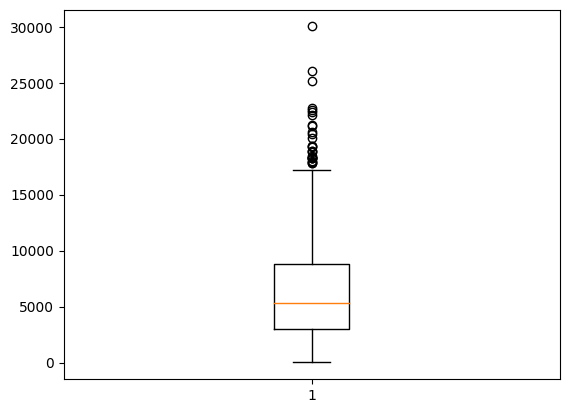

In [22]:
# num_earners

import matplotlib.pyplot as plt
import pandas as pd

testdf = incomedf.alias("testdf")
print(testdf.count())
testdf = testdf.dropna("all",subset="num_earners")
print(testdf.count())

print(testdf.agg(min("num_earners"), max("num_earners"), mean("num_earners")))

df = testdf.toPandas()
plt.boxplot(df["num_earners"])
plt.show()

First we check for nulls and find that 48 rows have nulls <br>
We will remove these rows as its unfair to impute a value here <br>
We could potentially use a population (sa2) dataset to make a model to predict the num_earners but there is no point because in the dataset if one row has a column with a null value then the other columns are all null too <br>
<br>

In [23]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="num_earners")
testdf = testdf.filter(testdf["num_earners"] > 25000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
117031337,30022,30,25962,65906,SYDNEY,NSW,Sydney - Haymarke...
206041122,26083,30,28806,51528,MELBOURNE,VIC,Melbourne
503021041,25161,34,54790,79517,CITY DELIVERY CENTRE,WA,Perth City


greatest number of earners in capital cities

In [24]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="num_earners")
testdf = testdf.filter(testdf["num_earners"] < 10)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
117011324,6,42,89790,83273,PORT BOTANY,NSW,Port Botany Indus...
117011325,5,30,41442,50626,SYDNEY DOMESTIC A...,NSW,Sydney Airport
128021537,8,32,26370,38451,SOUTHERN SUBURBS MC,NSW,Royal National Park
205021080,3,63,31114,22659,BRUMBY,VIC,Alps - East
206041127,8,38,93272,237158,WEST MELBOURNE,VIC,West Melbourne
208031192,8,54,50000,60501,MOORABBIN AIRPORT,VIC,Moorabbin Airport
306031162,5,60,101552,95663,WOOROONOORAN,QLD,Wooroonooran
308051532,8,45,90430,98604,CALLEMONDAH,QLD,Callemondah
310021279,3,40,93966,112085,LAKE MANCHESTER,QLD,Lake Manchester -...
404031104,4,50,31934,52302,ADELAIDE AIRPORT,SA,Adelaide Airport


lowest number of earners typically in parks/airports where barely any people live <br>
locations like west mebourne caught my eye with only 8 earners which i thought was incorrect but turns out its not: <br>
Population of West Melbourne. Last official estimated population of West Melbourne (as Statistical Area Level 2) was 3 people (on 2017-06-30). <br>
(population.com.au)

2289
2241
+---------------+---------------+------------------+
|min(median_age)|max(median_age)|   avg(median_age)|
+---------------+---------------+------------------+
|             15|             71|43.077197679607316|
+---------------+---------------+------------------+



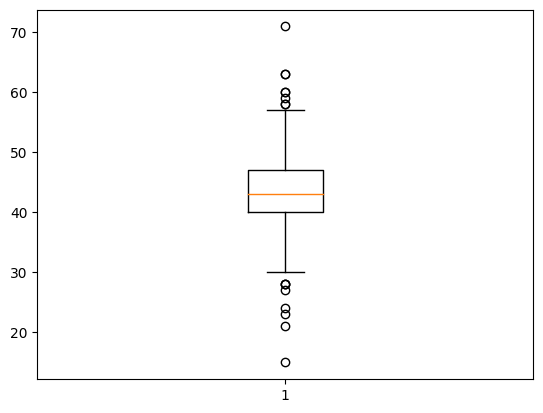

In [25]:
# median_age

testdf = incomedf.alias("testdf")
print(testdf.count())
testdf = testdf.dropna("all",subset="median_age")
print(testdf.count())

print(testdf.agg(min("median_age"), max("median_age"), mean("median_age")))

df = testdf.toPandas()
plt.boxplot(df["median_age"])
plt.show()

again 48 rows with nulls <br>
median ages below 20 and above 70 seem unreasonable so they will be removed considering mean retirement age is generally 65 years and the minimum age to work is around 15 years <br>

In [26]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_age")
testdf = testdf.filter(testdf["median_age"] > 70)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
504021052,5,71,1260,-1773,SAWYERS VALLEY,WA,Malmalling - Rese...


will be removed cause negative mean income

In [27]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_age")
testdf = testdf.filter(testdf["median_age"] < 20)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016


sa2 code doesnt exist in postcodes file for 15 year median working age so will be removed

2241
2239
+---------------+---------------+-----------------+
|min(median_age)|max(median_age)|  avg(median_age)|
+---------------+---------------+-----------------+
|             21|             63|43.07726663689147|
+---------------+---------------+-----------------+



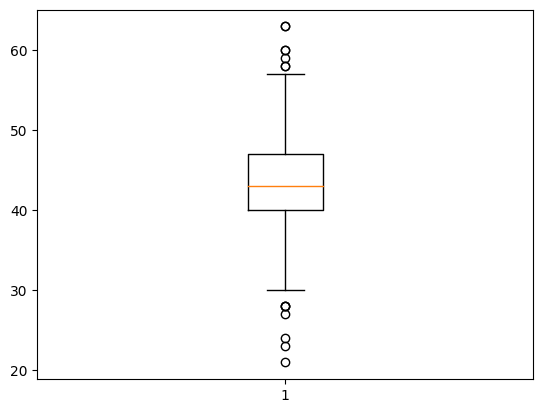

In [28]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_age")
print(testdf.count())
testdf = testdf.filter(testdf["median_age"] > 20)
testdf = testdf.filter(testdf["median_age"] < 70)
print(testdf.count())

print(testdf.agg(min("median_age"), max("median_age"), mean("median_age")))

df = testdf.toPandas()
plt.boxplot(df["median_age"])
plt.show()

2289
2241
+------------------+------------------+------------------+
|min(median_income)|max(median_income)|avg(median_income)|
+------------------+------------------+------------------+
|              1260|            178148| 50458.69522534583|
+------------------+------------------+------------------+



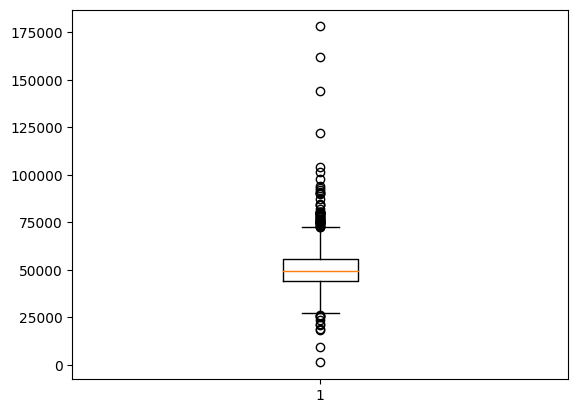

In [29]:
# median income

testdf = incomedf.alias("testdf")
print(testdf.count())
testdf = testdf.dropna("all",subset=["median_income"])
print(testdf.count())
print(testdf.agg(min("median_income"), max("median_income"), mean("median_income")))

df = testdf.toPandas()
plt.boxplot(df["median_income"])
plt.show()

again 48 rows with null will be removed

In [30]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_income")
testdf = testdf.filter(testdf["median_income"] > 90000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
206041127,8,38,93272,237158,WEST MELBOURNE,VIC,West Melbourne
306031162,5,60,101552,95663,WOOROONOORAN,QLD,Wooroonooran
308051532,8,45,90430,98604,CALLEMONDAH,QLD,Callemondah
310021279,3,40,93966,112085,LAKE MANCHESTER,QLD,Lake Manchester -...
406021143,2562,36,92288,95640,OLYMPIC DAM,SA,Roxby Downs
503021037,37,59,161893,356433,KINGS PARK,WA,Kings Park (WA)
506011111,4,43,143945,92309,ASHENDON,WA,Ashendon - Lesley
510021269,2834,38,90731,101819,PORT HEDLAND,WA,Port Hedland
510031271,3416,39,97795,98922,CANE,WA,Ashburton (WA)
801061068,4,53,121961,107326,CAPITAL HILL,ACT,Parkes (ACT) - South


The sa2 regions with high median income are mainly consisting of posh regions with a low population <br>

In [31]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_income")
testdf = testdf.filter(testdf["median_income"] < 30000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
110021194,3113,54,28976,35915,STANNUM,NSW,Tenterfield
117031337,30022,30,25962,65906,SYDNEY,NSW,Sydney - Haymarke...
124011451,14,63,21247,19071,THE DEVILS WILDER...,NSW,Blue Mountains - ...
128021537,8,32,26370,38451,SOUTHERN SUBURBS MC,NSW,Royal National Park
205031088,53,57,18177,32022,ELIZABETH ISLAND,VIC,French Island
205051099,23,53,18835,27804,ARBUCKLE,VIC,Alps - West
206041122,26083,30,28806,51528,MELBOURNE,VIC,Melbourne
210011227,19,46,27711,42355,ESSENDON FIELDS,VIC,Essendon Airport
315011395,352,40,23591,38363,AURUKUN,QLD,Aurukun
315011398,585,40,25757,34917,KOWANYAMA,QLD,Kowanyama - Pormp...


The sa2 regions with low median income consist of regions that few people live in and there is little access to a good job such as mountains/parks/islands/airports <br>

2289
2241
+----------------+----------------+------------------+
|min(mean_income)|max(mean_income)|  avg(mean_income)|
+----------------+----------------+------------------+
|           -1773|          356433|62742.204373047745|
+----------------+----------------+------------------+



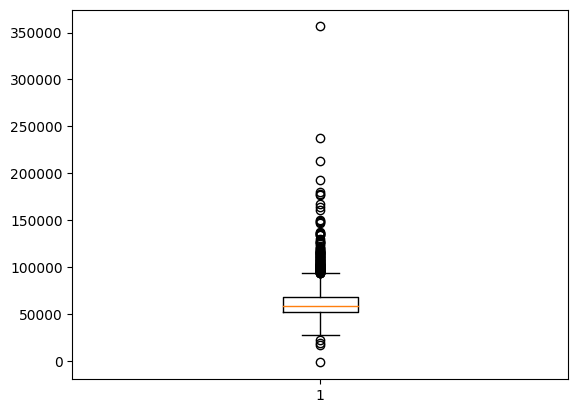

In [32]:
# mean income

testdf = incomedf.alias("testdf")
print(testdf.count())
testdf = testdf.dropna("all",subset=["mean_income"])
print(testdf.count())
print(testdf.agg(min("mean_income"), max("mean_income"), mean("mean_income")))

df = testdf.toPandas()
plt.boxplot(df["mean_income"])
plt.show()

again 48 rows removed due to null values <br>

In [33]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="mean_income")
testdf = testdf.filter(testdf["mean_income"] > 150000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
118011343,18432,44,77665,176403,DOUBLE BAY,NSW,Double Bay - Bell...
118011346,8478,48,74788,192463,ROSE BAY,NSW,Rose Bay - Vauclu...
118011347,5532,45,74887,164205,WOOLLAHRA,NSW,Woollahra
121041415,20612,47,75307,166807,MOSMAN,NSW,Mosman
206041127,8,38,93272,237158,WEST MELBOURNE,VIC,West Melbourne
206061138,10250,49,72451,177645,TOORAK,VIC,Toorak
503011032,5544,49,74999,213108,COTTESLOE,WA,Cottesloe
503011034,6781,47,65623,160696,PEPPERMINT GROVE,WA,Mosman Park - Pep...
503021037,37,59,161893,356433,KINGS PARK,WA,Kings Park (WA)
801061063,1312,48,87093,150020,FORREST,ACT,Forrest


The highest mean income comes from posh regions with low populations and from wealthy regions in major cities

In [34]:
testdf = incomedf.alias("testdf")
testdf = testdf.dropna("all",subset="median_income")
testdf = testdf.filter(testdf["median_income"] < 25000)
testdf = testdf.join(testpostcodedf, "sa2_code")
testdf = testdf.dropDuplicates(subset=["sa2_code"])
testdf

sa2_code,num_earners,median_age,median_income,mean_income,locality,state,SA2_NAME_2016
124011451,14,63,21247,19071,THE DEVILS WILDER...,NSW,Blue Mountains - ...
205031088,53,57,18177,32022,ELIZABETH ISLAND,VIC,French Island
205051099,23,53,18835,27804,ARBUCKLE,VIC,Alps - West
315011395,352,40,23591,38363,AURUKUN,QLD,Aurukun
504021052,5,71,1260,-1773,SAWYERS VALLEY,WA,Malmalling - Rese...
801031031,24,42,21385,54739,HUME,ACT,Hume
801051049,548,23,9306,16835,ANU,ACT,Acton


The lowest mean income is similar to the lowest median income and comes from locations where not many people live and not many jobs are available such as parks/islands/mountains

It is interesting seeing that the regions with the highest median income are generally different to the regions with the highest mean income <br>
Mean being bigger then median means that there are more highly wealthy people bringing the average up <br>
this is confirmed as the bigger mean income locations mostly focus around major cities with HIGH populations where these millionaires would generally live <br>
whereas the bigger median income regions revolve around niche locations with LOW populations  

## Population Data (JAI: needa script that downloads population data)

In [35]:
skip = list(range(7)) + [8] + list(range(2481, 2490)) + [2480]

fields_2b_renamed = ['S/T name', 'no.']

field_names = ['S/T name', 'SA2 code', 'SA2 name', 'no.']

for i in range (1, 19):
    string = 'no..' + str(i)
    fields_2b_renamed.append(string)
    field_names.append(string)

rename_to = ['State/Terr']
for i in range(0, 86, 5):
    col_name = "age "

    if i == 85:
        col_name += f"{i}+"
        rename_to.append(col_name)
        continue

    col_name += f"{i}-{i+4}"
    rename_to.append(col_name)

rename_to.append('Total')

rename_cols = dict(zip(fields_2b_renamed, rename_to))


In [36]:
import pandas as pd

pop_df = pd \
    .read_excel(
        '../data/tables/pop.xlsx',
        sheet_name = 'Table 3',
        skiprows = skip,
    ) \
    .get(field_names) \
    .rename(columns = rename_cols)

FileNotFoundError: [Errno 2] No such file or directory: '../data/tables/pop.xlsx'

Create custom categories for better interpretation:
- old: 60+
- middle age: 35-59
- young adult: 20-34
- adolescent: 10-19
- under 10: 0-9

Note: retiremet age in Australia is 66

In [ ]:
# get all age columns to be dropped
drop_cols = [string for string in pop_df.columns if string[:3] == 'age']

In [ ]:
groups = {
    'Under 10': [0, 10],
    'Adolescent': [10, 20],
    'Young adult': [20, 35],
    'Middle age': [35, 60],
    'Old': [60, 86]
}

for group, ages in groups.items():

    age_sum = 0
    for i in range(ages[0], ages[1], 5):

        if i == 85:
            age_range_str = f"age {i}+"
        else:
            age_range_str = f"age {i}-{i+4}"
            
        age_sum += pop_df[age_range_str]
        
    pop_df[group] = age_sum
 

# drop all columns containing age
pop_df_mod = pop_df.drop(axis=0, columns=drop_cols)

Convert population pandas dataframe to spark dataframe for later integration.

In [ ]:
pop_df_mod = pop_df_mod.convert_dtypes()
pop_df_mod.dtypes
pop_df_mod[pop_df_mod.isnull().any(axis=1)]
pop_df_mod = pop_df_mod.dropna()

21 cells feaaturing NA values were dropped here, since they were either totals or rows of entirely null values

In [ ]:
from pyspark.sql.types import *

mySchema = StructType([
    StructField("State/Terr", StringType()),
    StructField("SA2 code", StringType()),
    StructField("SA2 name", StringType()),
    StructField("Total", IntegerType()),
    StructField("Under 10", IntegerType()),
    StructField("Adolescent", IntegerType()),
    StructField("Young adult", IntegerType()),
    StructField("Middle age", IntegerType()),
    StructField("Old", IntegerType())
])

In [ ]:
pop_sdf = spark.createDataFrame(
    pop_df_mod,
    mySchema
)

In [ ]:
pop_sdf.show()

+---------------+---------+--------------------+-----+--------+----------+-----------+----------+----+
|     State/Terr| SA2 code|            SA2 name|Total|Under 10|Adolescent|Young adult|Middle age| Old|
+---------------+---------+--------------------+-----+--------+----------+-----------+----------+----+
|New South Wales|101021007|           Braidwood| 4330|     473|       403|        495|      1472|1487|
|New South Wales|101021008|             Karabar| 8546|    1082|      1075|       1818|      2858|1713|
|New South Wales|101021009|          Queanbeyan|11370|    1275|       916|       3129|      3681|2369|
|New South Wales|101021010|   Queanbeyan - East| 5093|     588|       406|       1460|      1718| 921|
|New South Wales|101021012|Queanbeyan West -...|12743|    1796|      1910|       2266|      4933|1838|
|New South Wales|101021610|             Googong| 6245|    1472|       696|       1569|      2192| 316|
|New South Wales|101021611|Queanbeyan Surrounds|16523|    2004|      2293

Get sum of each age group and create pie charts for each state and territory.

In [ ]:
pop_agg_st = pop_sdf.groupBy("State/Terr") \
    .sum("Under 10", "Adolescent", "Young adult", "Middle age", "Old")

pop_agg_st_df = pop_agg_st.toPandas()

In [ ]:
pop_agg_st_df.set_index("State/Terr", inplace=True)

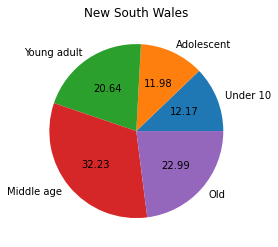

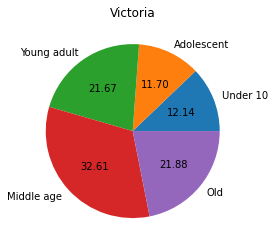

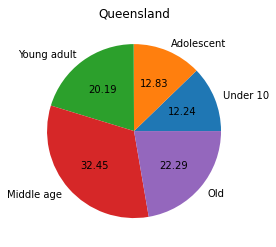

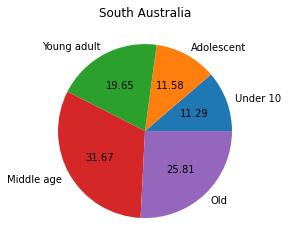

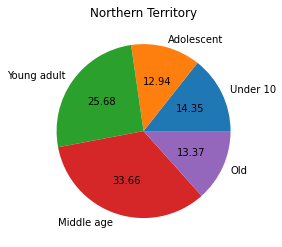

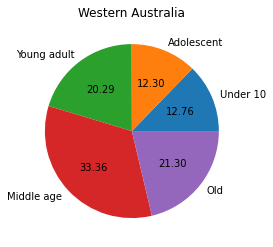

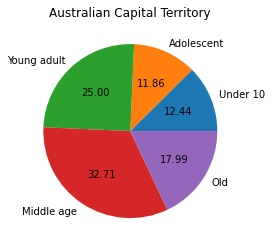

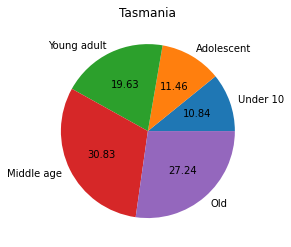

In [ ]:
from matplotlib import pyplot as plt

states = list(pop_agg_st_df.index)

i = 0
for state in states:
    data = list(pop_agg_st_df.loc[state])

    plt.figure(i)
    plt.title(state)
    plt.pie(data, autopct='%.2f', labels=list(groups.keys()))
    
    i += 1

plt.show()

It is evident that the distribution of the age groups for the states and territories are extremely similar.

Let us examine the boxplots for the same data.

SA2 Shapefile: https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files

# Fraud Data

### Consumer Fraud

In [37]:
consumerfrauddf = spark.read.option("header","True").csv("../data/tables/consumer_fraud_probability.csv")
print(consumerfrauddf.count())
consumerfrauddf = consumerfrauddf.dropna("any")
print(consumerfrauddf.count())
consumerfrauddf = consumerfrauddf.withColumn("fraud_probability", col("fraud_probability").cast('double'))
consumerfrauddf.limit(5)

34864
34864


user_id,order_datetime,fraud_probability
6228,2021-12-19,97.6298077657765
21419,2021-12-10,99.24738020302328
5606,2021-10-17,84.05825045251777
3101,2021-04-17,91.42192091901347
22239,2021-10-19,94.70342477508035


No null values

In [38]:
testdf = consumerfrauddf.filter(consumerfrauddf["user_id"] > 0)
testdf = testdf.filter(consumerfrauddf["user_id"] <= 24081)
print(testdf.count())

34864


All consumer ids valid 

In [39]:
import datetime
start_date = datetime.datetime(2021, 2, 28) 
end_date = datetime.datetime(2022, 2, 28)
testdf = consumerfrauddf.filter(consumerfrauddf["order_datetime"] >= start_date)
testdf = testdf.filter(consumerfrauddf["order_datetime"] <= end_date)
testdf.count()

34864

All datetimes valid

+----------------------+----------------------+----------------------+
|min(fraud_probability)|max(fraud_probability)|avg(fraud_probability)|
+----------------------+----------------------+----------------------+
|     8.287143531552802|     99.24738020302328|    15.120090644154585|
+----------------------+----------------------+----------------------+



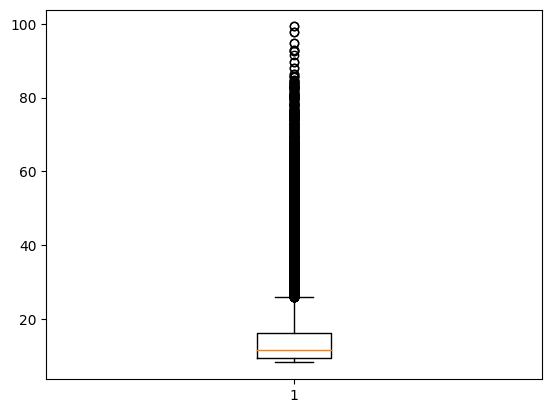

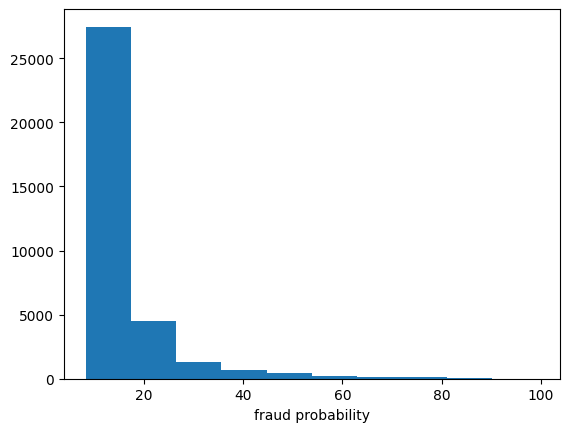

In [40]:
import matplotlib.pyplot as plt

df = consumerfrauddf.toPandas()

print(consumerfrauddf.agg(min("fraud_probability"), max("fraud_probability"), mean("fraud_probability")))

plt.boxplot(df["fraud_probability"])
plt.show()

plt.hist(df["fraud_probability"])
plt.xlabel("fraud probability")
plt.show() 

Most consumer fraud probabilities are towards lower end of spectrum

+--------------------+--------------------+--------------------+
|min(fraudulent_days)|max(fraudulent_days)|avg(fraudulent_days)|
+--------------------+--------------------+--------------------+
|                   1|                   6|   1.732114467408585|
+--------------------+--------------------+--------------------+

+---------------+---------+
|fraudulent_days|frequency|
+---------------+---------+
|              1|     9291|
|              2|     7555|
|              3|     2723|
|              4|      506|
|              5|       48|
|              6|        5|
+---------------+---------+



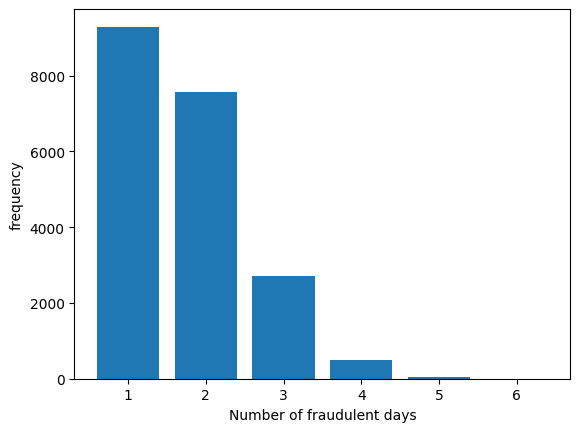

In [41]:
testdf = consumerfrauddf.groupBy("user_id").agg(count("user_id").alias("fraudulent_days"))
print(testdf.agg(min("fraudulent_days"), max("fraudulent_days"), mean("fraudulent_days")))
testdf = testdf.groupBy("fraudulent_days").agg(count("fraudulent_days").alias("frequency")).orderBy("fraudulent_days")
print(testdf)

df = testdf.toPandas()
plt.bar(df["fraudulent_days"],df["frequency"])
plt.xlabel("Number of fraudulent days")
plt.ylabel("frequency")
plt.show() 

First table shows that the minimum number of times a user had a fraudulent transaction day was 1 and the maximum number of times was 6 with an average of 1.7 fraudulent days for any given user <br>
Table 2 and the bar chart show the frequency

### Merchant Fraud

In [42]:
merchantfrauddf = spark.read.option("header","True").csv("../data/tables/merchant_fraud_probability.csv")
print(merchantfrauddf.count())
merchantfrauddf = merchantfrauddf.dropna("any")
print(merchantfrauddf.count())
merchantfrauddf = merchantfrauddf.withColumn("fraud_probability", col("fraud_probability").cast('double'))
merchantfrauddf.limit(5)

114
114


merchant_abn,order_datetime,fraud_probability
19492220327,2021-11-28,44.403658647495355
31334588839,2021-10-02,42.75530083865367
19492220327,2021-12-22,38.867790051131095
82999039227,2021-12-19,94.1347004808891
90918180829,2021-09-02,43.32551731714902


No null values

In [43]:
# Invalid merchant abns will be removed when joining

In [44]:
import datetime
start_date = datetime.datetime(2021, 2, 28) 
end_date = datetime.datetime(2022, 2, 28)
testdf = merchantfrauddf.filter(merchantfrauddf["order_datetime"] >= start_date)
testdf = testdf.filter(merchantfrauddf["order_datetime"] <= end_date)
testdf.count()

114

All datetimes valid

+----------------------+----------------------+----------------------+
|min(fraud_probability)|max(fraud_probability)|avg(fraud_probability)|
+----------------------+----------------------+----------------------+
|     18.21089142894488|      94.1347004808891|    40.419334695018094|
+----------------------+----------------------+----------------------+



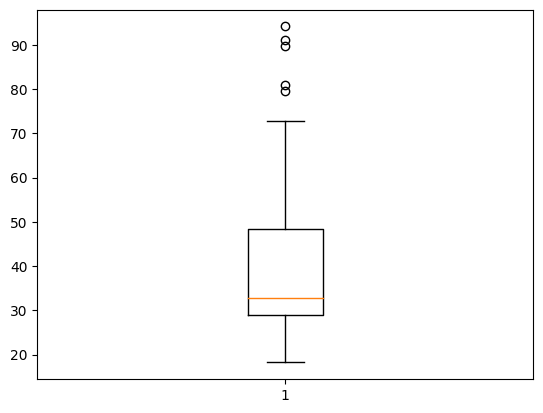

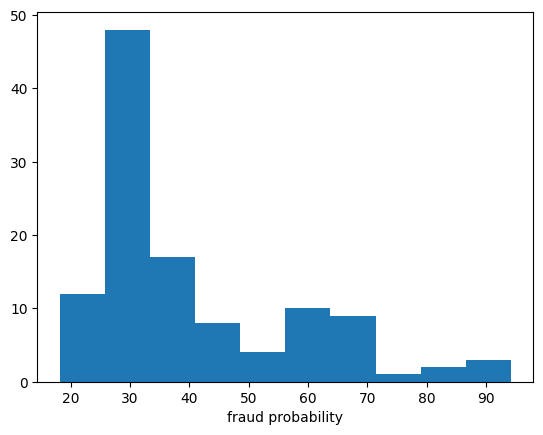

In [45]:
import matplotlib.pyplot as plt

df = merchantfrauddf.toPandas()

print(merchantfrauddf.agg(min("fraud_probability"), max("fraud_probability"), mean("fraud_probability")))

plt.boxplot(df["fraud_probability"])
plt.show()

plt.hist(df["fraud_probability"])
plt.xlabel("fraud probability")
plt.show() 

Merchant fraud probabilities are more evenly spread out then user ones

+--------------------+--------------------+--------------------+
|min(fraudulent_days)|max(fraudulent_days)|avg(fraudulent_days)|
+--------------------+--------------------+--------------------+
|                   1|                  12|  1.8688524590163935|
+--------------------+--------------------+--------------------+

+---------------+---------+
|fraudulent_days|frequency|
+---------------+---------+
|              1|       44|
|              2|        5|
|              3|        6|
|              4|        1|
|              5|        1|
|              6|        1|
|              7|        1|
|              8|        1|
|             12|        1|
+---------------+---------+



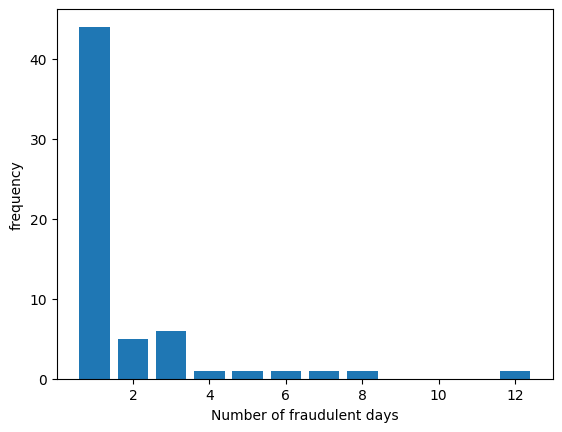

In [46]:
testdf = merchantfrauddf.groupBy("merchant_abn").agg(count("merchant_abn").alias("fraudulent_days"))
print(testdf.agg(min("fraudulent_days"), max("fraudulent_days"), mean("fraudulent_days")))
testdf = testdf.groupBy("fraudulent_days").agg(count("fraudulent_days").alias("frequency")).orderBy("fraudulent_days")
print(testdf)

df = testdf.toPandas()
plt.bar(df["fraudulent_days"],df["frequency"])
plt.xlabel("Number of fraudulent days")
plt.ylabel("frequency")
plt.show() 

Most merchants had a low number of fraudulent days